# Projet Métaheuristiques - Placement de Capteurs sur une grille discretisée

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from time import perf_counter
import scipy as sc
rng = np.random.default_rng(42)

## Lecture de l'instance et convertion à un format traitable

In [2]:
def file_to_instance(filepath):
    '''Function that transforms a .dat file with a certain number of coordinates
    into an instance of the sensor positioning problem. The function also identifies
    if the instance is generated ramdomly or if it was created by the exclusion of
    certain cible coordinates. In the first case, the instance is generated directly
    from the given coordinates. In the second, a full grid is generated and the
    indicated cibles are removed.

    Parameters:
    - filepath: string, indicates the path to a .dat file
    Returns:
    - instance: dict, tuple, int; stores the coordinates of the cibles in the instance.'''
    # read file
    df = pd.read_csv(filepath, delimiter = "\t")
    # get the column name
    col = df.columns[0] # it should only have one column name

    column = df[col] # get the series of the actual data

    left, right = col.split(":") # retrieving information
    if left.strip() == 'taille de la grille complète':
        # fall into the first case: not random
        # cible removal
        N = int(right.strip("=;")) # grid size
        n = int(np.sqrt(N))

        coordinates = [(0, 0)]
        # treating the coordinates
        for el in column:
            aux = el.split(':', maxsplit=1)
            try:
                ind = int(aux[0].strip()) # this index is very much an accessory but lets keep it
                # if it is one of the string lines of the series, it will not crash
                # makes sure we only get numerical values
            except ValueError:
                continue # if it's not numerical, moves on to the next line
            a, b = map(int, aux[1].strip(" ()").split(",")) # treats teh tuple as a string and gets the coordinates
            coordinates.append((a,b))

        # create the full instance
        instance = []
        for i in range(n):
            for j in range(n):
                if (i, j) not in coordinates:
                    instance.append((i, j))

    elif left.strip() == "Nombre de cibles": # Vai adicionando elemento por elemento
        instance = []
        for i in range(int(right.strip())):
            ind, a, b = df[col][i].split()
            if a != '0.00' or b != '0.00':
                instance.append((float(a.strip()),float(b.strip(" ;"))))

    return instance

# Classe principale

In [17]:
class SensorCoverageSolver:
    def __init__(self, cibles: list[tuple[float, float]], rcapt: float, rcom: float, puits: tuple[float, float]):
        '''Builds a solver object for the placement of sensors in a grid problem.'''
        self.cibles = np.asarray(cibles)
        self.rcapt = rcapt
        self.rcom = rcom
        self.puits = np.asarray(puits)
        self.n = len(cibles)
        self.dist_matrix = self.distance_matrix()
        # control variables
        self.objective = 0
        self.sensors = None

    def distance_matrix(self) -> np.ndarray:
        '''Computes the distance between points in the grid.'''
        # Usando broadcasting para eficiência
        diff = self.cibles[:, np.newaxis, :] - self.cibles[np.newaxis, :, :]
        d = np.sqrt(np.sum(diff**2, axis=2))
        return d

    def reachable_points(self, i: int) -> set[int]:
        '''For a given point i, returns set of reachable points within R_capt.'''
        # np.where retorna uma tupla, precisamos pegar o primeiro elemento
        indices = np.where(self.dist_matrix[i, :] <= self.rcapt)[0]
        return set(indices)

    def communicable_points(self, i: int) -> set[int]:
        '''For a given point i, returns set of communicable points within R_com.'''
        indices = np.where(self.dist_matrix[i, :] <= self.rcom)[0]
        return set(indices)

    def coverage_heuristics(self, use_max_dist = True) -> set[int]:
        '''Heurística para encontrar uma solução viável.'''

        sensors = set() # Sensores
        reachable = set() # Cibles que podem ser captadas
        communicable = set() # Sensores comunicáveis

        # Encontrar ponto mais próximo do puits para começar
        # podemos tentar fazer com o ponto mais longe também
        if use_max_dist:
            max_dist = -np.inf
            start_point = -1
            for i in range(self.n):
                dist = np.linalg.norm(self.cibles[i] - self.puits)
                if dist > max_dist:
                    max_dist = dist
                    start_point = i
        else:
            min_dist = np.inf
            start_point = -1
            for i in range(self.n):
                dist = np.linalg.norm(self.cibles[i] - self.puits)
                if dist < min_dist:
                    min_dist = dist
                    start_point = i

        # Adicionar ponto inicial
        sensors.add(start_point)
        reachable.update(self.reachable_points(start_point))
        communicable.update(self.communicable_points(start_point))

        # Loop principal
        while len(reachable) < self.n:
            best_point = -1
            best_new_coverage = -1

            # Iterar sobre os pontos comunicáveis que ainda não são sensores
            # Convertendo para lista para poder iterar
            candidates = list(communicable - sensors)

            for i in candidates:
                # Pontos que este sensor alcançaria
                i_reachable = self.reachable_points(i)
                # Novas cibles que seriam cobertas
                new_reachable = i_reachable - reachable
                num_new = len(new_reachable)

                if num_new > best_new_coverage:
                    best_new_coverage = num_new
                    best_point = i

            # Se não encontrou ponto que cubra novas cibles
            if best_point == -1:
                # Procurar qualquer ponto não coberto
                for i in range(self.n):
                    if i not in reachable:
                        best_point = i
                        break

            # Se ainda não encontrou, todos estão cobertos
            if best_point == -1:
                break

            # Adicionar o melhor ponto
            sensors.add(best_point)
            reachable.update(self.reachable_points(best_point))
            communicable.update(self.communicable_points(best_point))

        self.sensors = sensors # current solution
        self.objective = len(sensors) # current objective value
        return [self.cibles[i] for i in sensors]

    def solution_to_neighbor(self, random_walk = False, max_step = 4):
        '''Given a solver, explores a neighborhood of the current solution.'''
        # check if this would be better as a class method
        # in such case, updates a self.sensors (solution) if the next solution
        # improves the value
        if self.objective == 0:
            cur_sensors = self.coverage_heuristics()
        cur_sol = self.sensors
        cur_val = self.objective

        # 1 - randomly select a sensor and remove it
        # 2 - choose another one from the communicable set and remove it too
        # 3 - try to place another sensor in the empty space
        # 5 - check if it's a solution

        # 1
        i = int(np.random.choice(list(cur_sol),1)) # choose one sensor to remove
        new_set = cur_sol - {i} # remove i from current solution and store it

        i_nbh = self.communicable_points(i) # indexes
        nbh = i_nbh.intersection(new_set) # get communicable neighborhood of sensors from i
        remove_set  = set() # will store the evolution of the neighborhoods

        counts = np.sum(self.dist_matrix <= self.rcapt, axis=0) # number os sensors covering each cible
        counts[list(i_nbh)] += -1 # one less sensor covering it
        unreachable = set(np.where(counts == 0)[0])

        aux_nbh = list(nbh) # bug fix
        np.random.shuffle(aux_nbh)

        niter = 0 # control variable
        for j in aux_nbh: # gets a random sensor in this neighborhood
            niter += 1
            # 3
            remove_set.add(j) # step that moves across neighborhoods V1, V2,...,Vm-1
            j_nbh = self.reachable_points(j) - cur_sol # we do not want sensors in this one
            # since we are looking for empty spots

            if random_walk:
                new_pos = np.random.choice(list(j_nbh),1) # to be tested
            else:
                # softmax to we can tweak the sensors proportionally to the distance
                # more likely to move to a closer point
                # guarantees stability of the solution
                mask = self.dist_matrix[j] <= self.rcapt
                mask[[i,j]] = False
                x = self.dist_matrix[j, mask]
                # print(j_nbh)
                new_pos = np.random.choice(list(j_nbh),1,
                                        p=sc.special.softmax(x))[0]
            new_set -= remove_set # remove last sensor position
            new_set.add(new_pos) # add new position
            new_pos_nbh = self.reachable_points(new_pos)
            unreachable -= unreachable.intersection(new_pos_nbh)
            # check if is solution
            if len(unreachable) == 0:
                # if it's a solution, return it
                break
            if niter == max_step:
                break

        return [self.cibles[i] for i in new_set]

    def vnd(self, kmax: int = 3, max_iter: int = 50, pair_samples: int = 300,
            seed: int | None = 0, start_use_max_dist: bool = False):

        n = self.n
        if n == 0:
            self.sensors = set()
            self.objective = 0
            return []

        # ---------- Precompute neighborhoods for speed ----------
        # cover[i] = boolean mask of cibles covered by a sensor placed at i (Rcapt)
        # com[i]   = boolean mask of cibles that are within comm range of i (Rcom)
        cover = (self.dist_matrix <= self.rcapt)
        com = (self.dist_matrix <= self.rcom)

        # distance from each cible to sink (puits)
        puits_d = np.linalg.norm(self.cibles - self.puits, axis=1)
        can_talk_to_puits = (puits_d <= self.rcom)

        ALL = np.ones(n, dtype=bool)

        # ---------- Feasibility checks ----------
        def is_covered(sensors_set: set[int]) -> bool:
            mask = np.zeros(n, dtype=bool)
            for i in sensors_set:
                mask |= cover[i]
            return mask.all()

        def is_connected_to_puits(sensors_set: set[int]) -> bool:

            sensors_list = list(sensors_set)
            idx = {v: t for t, v in enumerate(sensors_list)}
            m = len(sensors_list)

            # Start frontier: sensors directly connected to puits
            start = [v for v in sensors_list if can_talk_to_puits[v]]

            visited = np.zeros(m, dtype=bool)
            stack = [idx[v] for v in start]
            for s in stack:
                visited[s] = True

            while stack:
                u_pos = stack.pop()
                u = sensors_list[u_pos]
                # neighbors among sensors: com[u] tells which cibles are within Rcom of u
                # we only care those that are sensors
                for v in sensors_list:
                    v_pos = idx[v]
                    if not visited[v_pos] and com[u, v]:
                        visited[v_pos] = True
                        stack.append(v_pos)

            return visited.all()

        def is_feasible(sensors_set: set[int]) -> bool:
            return is_covered(sensors_set) and is_connected_to_puits(sensors_set)

        # ---------- Greedy constructive repair (keeps connectivity) ----------
        def greedy_repair(sensors_set: set[int]) -> set[int]:
            sensors = set(sensors_set)

            # If empty, must start with a node that can talk to puits
            if not sensors:
                candidates = np.where(can_talk_to_puits)[0]
                if candidates.size == 0:
                    return sensors  # infeasible instance
                # pick start with max coverage (tie broken by closer to puits)
                best = None
                best_cov = -1
                best_dist = np.inf
                for i in candidates:
                    cov_i = int(cover[i].sum())
                    d_i = float(puits_d[i])
                    if (cov_i > best_cov) or (cov_i == best_cov and d_i < best_dist):
                        best = int(i)
                        best_cov = cov_i
                        best_dist = d_i
                sensors.add(best)

            # Maintain covered mask
            covered_mask = np.zeros(n, dtype=bool)
            for s in sensors:
                covered_mask |= cover[s]

            # Maintain "connected frontier" candidates: nodes that keep connectivity if added
            # A node is addable if it is within Rcom of any existing sensor (or directly to puits when sensors nonempty too).
            def addable_nodes() -> np.ndarray:
                # union of com ranges of sensors
                addable = np.zeros(n, dtype=bool)
                for s in sensors:
                    addable |= com[s]
                addable |= can_talk_to_puits  # always allow direct-to-sink additions
                # cannot add something already a sensor
                for s in sensors:
                    addable[s] = False
                return addable

            # Greedy loop: add sensors until full coverage (connectivity preserved by addable condition)
            safety = 0
            while not covered_mask.all():
                safety += 1
                if safety > 10_000:
                    break

                addable = addable_nodes()
                candidates = np.where(addable)[0]
                if candidates.size == 0:
                    break  # cannot repair

                # choose candidate maximizing newly covered cibles
                best = None
                best_gain = -1
                best_dist = np.inf
                for i in candidates:
                    gain = int((cover[i] & (~covered_mask)).sum())
                    d_i = float(puits_d[i])
                    if (gain > best_gain) or (gain == best_gain and d_i < best_dist):
                        best = int(i)
                        best_gain = gain
                        best_dist = d_i

                if best is None:
                    break

                sensors.add(best)
                covered_mask |= cover[best]

            return sensors

        # ---------- Local reduction (remove redundants) ----------
        def local_reduce(sensors_set: set[int]) -> set[int]:
            sensors = set(sensors_set)
            improved = True
            while improved and sensors:
                improved = False
                # try remove sensors in random-ish order for variety but deterministic with rng
                order = list(sensors)
                rng.shuffle(order)
                for s in order:
                    trial = set(sensors)
                    trial.remove(s)
                    if is_feasible(trial):
                        sensors = trial
                        improved = True
                        break
            return sensors

        # ---------- Neighborhood exploration (best neighbor) ----------
        def best_neighbor_V1(x: set[int]) -> set[int] | None:
            # Try removing 1 sensor, best is any feasible with smaller cardinality
            if len(x) <= 1:
                return None
            best = None
            best_val = len(x)
            for s in list(x):
                trial = set(x)
                trial.remove(s)
                if is_feasible(trial):
                    if len(trial) < best_val:
                        best = trial
                        best_val = len(trial)
                        if best_val == len(x) - 1:
                            # can't do better than -1 in V1
                            return best
            return best

        def best_neighbor_remove_k_and_repair(x: set[int], k_remove: int) -> set[int] | None:
            if len(x) <= k_remove:
                return None

            x_list = list(x)
            best = None
            best_val = len(x)

            # sample subsets to keep runtime reasonable
            # deterministic due to rng
            for _ in range(pair_samples):
                rem = set(rng.choice(x_list, size=k_remove, replace=False).tolist())
                base = set(x) - rem

                # repair then reduce
                y = greedy_repair(base)
                if not is_feasible(y):
                    continue
                y = local_reduce(y)

                if len(y) < best_val:
                    best = y
                    best_val = len(y)

            return best

        # ---------- Initial solution ----------
        # Prefer an initial solution that is actually connected to puits
        # We use greedy_repair starting from either existing sensors or from heuristic
        if self.sensors is not None and len(self.sensors) > 0:
            x = set(self.sensors)
        else:
            # your heuristic may produce something not connected; we still use it as a start point then repair
            _ = self.coverage_heuristics(use_max_dist=start_use_max_dist)
            x = set(self.sensors) if self.sensors is not None else set()

        x = greedy_repair(x)
        if not is_feasible(x):
            # last attempt: start from scratch
            x = greedy_repair(set())
        x = local_reduce(x)

        if not is_feasible(x):
            # no feasible solution found
            self.sensors = x
            self.objective = len(x)
            return [self.cibles[i] for i in x]

        # ---------- VND main loop ----------
        for _ in range(max_iter):
            k = 1
            improved_any = False

            while k <= kmax:
                if k == 1:
                    x_candidate = best_neighbor_V1(x)
                elif k == 2:
                    x_candidate = best_neighbor_remove_k_and_repair(x, k_remove=2)
                else:
                    x_candidate = best_neighbor_remove_k_and_repair(x, k_remove=3)

                if x_candidate is not None and len(x_candidate) < len(x):
                    x = x_candidate
                    k = 1
                    improved_any = True
                else:
                    k += 1

            if not improved_any:
                break

        self.sensors = x
        self.objective = len(x)
        return [self.cibles[i] for i in x]

In [18]:
def plot_solution(cibles, sensors, filename, rcapt, rcom, save=True):
    x, y = zip(*cibles)
    x_c, y_c = zip(*sensors)

    plt.figure()
    for sensor_x, sensor_y in sensors:
        circle = plt.Circle((sensor_x, sensor_y), rcapt,
                        alpha=0.1, fill=True, linewidth=0.5)
        plt.gca().add_patch(circle)

    plt.scatter(x, y, color='blue', s=15, alpha=0.7, label='cibles')

    if sensors:
        plt.scatter(x_c, y_c, color='red', s=60, marker='o',
                    edgecolors='black', linewidth=1, label='sensors')

    plt.scatter([0], [0], color='green', s=100, marker='s',
                edgecolors='black', linewidth=1.5, label='puits')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Sensors and coverage area {rcapt = }, {rcom = })')
    plt.grid(True, alpha=0.2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if save:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

## Examples

In [19]:
puits = (0, 0)
rcapt, rcom = 2.0, 3.0
# 1.0, 1.0 # Other values to test
# 1.0, 2.0
# 2.0, 2.0
# 2.0, 3.0

### Premier placement - plus loin du puits

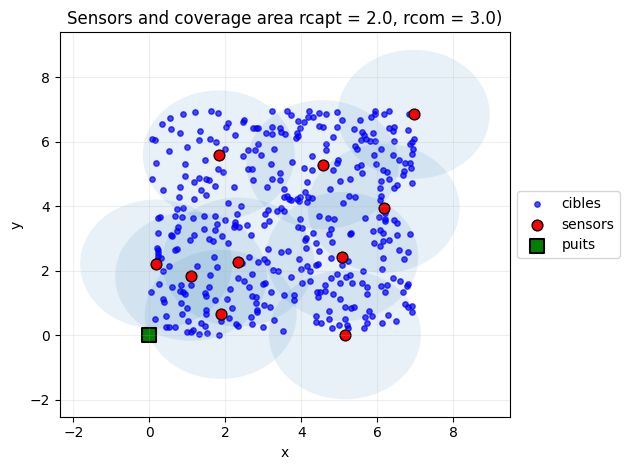

In [20]:
# cibles = file_to_instance(fr"C:\Users\gabri\Desktop\ENSTA\3A SOD\Méta-Heuristiques\Gabriel_Bastianello\Projet-Meta-Heuristiques\Projet de métaheuristiques - Instances cibles générées aléatoirement\captANOR150_7_4.dat")
cibles = file_to_instance("/content/captANOR400_7_10_2021.dat")
solver = SensorCoverageSolver(cibles, rcapt, rcom, puits)
sensors = solver.coverage_heuristics()
plot_solution(cibles, sensors,"...", rcapt, rcom, False)

/tmp/ipython-input-2711885328.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.random.choice(list(cur_sol),1)) # choose one sensor to remove


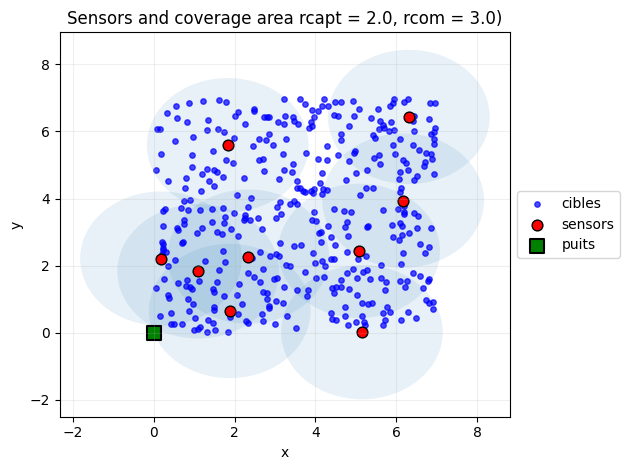

In [21]:
best_solution = solver.vnd()
plot_solution(cibles, best_solution, "...", rcapt, rcom, False)

## Benchmark - max_dist du puits

Description:
- Calcul du temps d'une execution de l'heuristique pour trouver une solution réalisable pour:
    - toute instance
    - toute valeur de R_capt et R_com
- Enregistrement d'images pour chaque solution
- Génération d'un tableau de résultats

In [ ]:
puits = (0, 0)
Rcapt, Rcom = [1.0, 1.0, 2.0, 2.0], [1.0, 2.0, 2.0, 3.0]

In [ ]:
random_folder = "../Projet-Meta-Heuristiques/Projet de métaheuristiques - Instances cibles générées aléatoirement"
truncated_folder = "../Projet-Meta-Heuristiques/Projet de métaheuristiques - Instances grilles tronquées"

random_files = Path(random_folder)
ord_rand = sorted(random_files.glob("*.dat"))

# reading the truncated instances
truncated_files = Path(truncated_folder)
ord_trunc = sorted(truncated_files.glob("*.dat")) # orders files by lexicographic order
# and takes only the .dat files, in any case there is something different in the folder

truncated_times, random_times = {}, {}
trunc_values, rand_values = {}, {}

truncated_names = [str(p).split("/")[-1].split(".")[0] for p in ord_trunc]
random_names = [str(p).split("/")[-1].split(".")[0] for p in ord_rand]

### Instances Grilles Tronquées

In [ ]:
for path, name in zip(ord_trunc, truncated_names):
    line = []
    values = []
    for cap, com in zip(Rcapt, Rcom):
        # defining the object to work with
        cible = file_to_instance(path) # opens file
        solver = SensorCoverageSolver(cible, cap, com, puits) # creates instance of the solver class

        t0 = perf_counter() # start timer
        sensors = solver.greedy_initial() # solve
        elapsed = perf_counter() - t0 # get computation time

        line.append(elapsed) # save results indexed by R values
        values.append(solver.objective)

        plot_solution(cible, sensors,
                    "SolutionInitiale/" + name + f"{cap}{com}" + "_sol_realisable.pdf",
                    cap, com)

    truncated_times[name] = line # saving results by instance
    trunc_values[name] = values

df_trunc = pd.DataFrame(truncated_times)
df_trunc_values = pd.DataFrame(trunc_values)

In [ ]:
df_trunc
# order
# 1.0 1.0
# 1.0 2.0
# 2.0 2.0
# 2.0 3.0

,grille1010_1,grille1010_2,grille1515_1,grille1515_2,grille2020_1,grille2020_2,grille2525_1,grille2525_2,grille3030_1,grille3030_2,grille4040_1,grille4040_2
0,0.003464,0.004519,0.021411,0.017910,0.055954,0.073886,0.098019,0.147560,0.286191,0.387365,1.082667,1.656711
1,0.004848,0.005792,0.025910,0.022868,0.087436,0.090708,0.149148,0.248942,0.431598,0.533982,1.549638,1.993882
2,0.003744,0.003765,0.016890,0.014495,0.042172,0.068396,0.105046,0.155741,0.215449,0.316102,0.902598,1.491537
3,0.003680,0.003177,0.016972,0.018029,0.060720,0.050782,0.081543,0.154118,0.210610,0.300965,0.979519,1.356126


In [ ]:
df_trunc_values

,grille1010_1,grille1010_2,grille1515_1,grille1515_2,grille2020_1,grille2020_2,grille2525_1,grille2525_2,grille3030_1,grille3030_2,grille4040_1,grille4040_2
0,40,46,94,96,147,158,177,253,306,367,495,637
1,28,34,64,69,108,122,141,192,208,274,386,489
2,19,20,40,41,63,72,88,111,118,158,220,276
3,15,15,29,30,48,51,61,75,89,109,159,190


### Instances Générées aléatoirement

In [ ]:
for path, name in zip(ord_rand, random_names):
    line = []
    values = []
    for cap, com in zip(Rcapt, Rcom):
        # defining the object to work with
        cible = file_to_instance(path) # opens file
        solver = SensorCoverageSolver(cible, cap, com, puits) # creates instance of the solver class

        t0 = perf_counter() # start timer
        sensors = solver.greedy_initial() # solve
        elapsed = perf_counter() - t0 # get computation time

        line.append(elapsed) # save results indexed by R values
        values.append(solver.objective)

        plot_solution(cible, sensors,
                    "SolutionInitiale/" + name + f"{cap}{com}" + "_sol_realisable.pdf",
                    cap, com)

    random_times[name] = line # saving results by instance
    rand_values[name] = values

df_rand = pd.DataFrame(random_times)
df_rand_values = pd.DataFrame(rand_values)

In [ ]:
df_rand

,captANOR150_7_4,captANOR1600_16_100_2021,captANOR400_7_10_2021,captANOR900_14_20_2021
0,0.014239,1.671309,0.057558,0.446736
1,0.010357,1.517944,0.054017,0.438699
2,0.006490,0.837779,0.035476,0.298151
3,0.004881,0.812987,0.034211,0.284288


In [ ]:
df_rand_values

,captANOR150_7_4,captANOR1600_16_100_2021,captANOR400_7_10_2021,captANOR900_14_20_2021
0,35,180,38,129
1,23,119,26,89
2,10,49,11,39
3,7,38,10,33


In [ ]:
aux_index = [f"({cap}, {com})" for cap, com in zip(Rcapt,Rcom)]
df_trunc.to_latex("SolutionInitiale/truncated_initial_solutions.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Temps d'execution d'heuristique pour trouver une solution réalisable sur une instance tronquée.")
df_rand.to_latex("SolutionInitiale/random_initial_solutions.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Temps d'execution d'heuristique pour trouver une solution réalisable sur une instance générée aléatoirement.")
df_trunc_values.to_latex("SolutionInitiale/truncated_initial_values.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Fonction objective d'heuristique pour trouver une solution réalisable sur une instance tronquée.")
df_rand_values.to_latex("SolutionInitiale/random_initial_values.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Fonction objective d'heuristique pour trouver une solution réalisable sur une instance générée aléatoirement.")

## Benchmark - min_dist du puits

In [ ]:
truncated_times, random_times = {}, {}
trunc_values, rand_values = {}, {}

### Instances générées aléatoirement

In [ ]:
for path, name in zip(ord_rand, random_names):
    line = []
    values = []
    for cap, com in zip(Rcapt, Rcom):
        # defining the object to work with
        cible = file_to_instance(path) # opens file
        solver = SensorCoverageSolver(cible, cap, com, puits) # creates instance of the solver class

        t0 = perf_counter() # start timer
        sensors = solver.greedy_initial(False) # solve
        elapsed = perf_counter() - t0 # get computation time

        line.append(elapsed) # save results indexed by R values
        values.append(solver.objective)

        plot_solution(cible, sensors,
                    "SolutionInitiale2/" + name + f"{cap}{com}" + "_sol_realisable.pdf",
                    cap, com)

    random_times[name] = line # saving results by instance
    rand_values[name] = values

df_rand = pd.DataFrame(random_times)
df_rand_values = pd.DataFrame(rand_values)

In [ ]:
df_rand

,captANOR150_7_4,captANOR1600_16_100_2021,captANOR400_7_10_2021,captANOR900_14_20_2021
0,0.017067,1.641265,0.050846,0.457760
1,0.012292,1.488709,0.057433,0.420002
2,0.007030,0.904919,0.033383,0.241301
3,0.007289,0.856531,0.038348,0.272766


In [ ]:
df_rand_values

,captANOR150_7_4,captANOR1600_16_100_2021,captANOR400_7_10_2021,captANOR900_14_20_2021
0,34,179,37,132
1,25,122,25,87
2,11,50,11,37
3,8,41,10,30


### Instances tronquées

In [ ]:
for path, name in zip(ord_trunc, truncated_names):
    line = []
    values = []
    for cap, com in zip(Rcapt, Rcom):
        # defining the object to work with
        cible = file_to_instance(path) # opens file
        solver = SensorCoverageSolver(cible, cap, com, puits) # creates instance of the solver class

        t0 = perf_counter() # start timer
        sensors = solver.greedy_initial(False) # solve
        elapsed = perf_counter() - t0 # get computation time

        line.append(elapsed) # save results indexed by R values
        values.append(solver.objective)

        plot_solution(cible, sensors,
                    "SolutionInitiale2/" + name + f"{cap}{com}" + "_sol_realisable.pdf",
                    cap, com)

    truncated_times[name] = line # saving results by instance
    trunc_values[name] = values

df_trunc = pd.DataFrame(truncated_times)
df_trunc_values = pd.DataFrame(trunc_values)

In [ ]:
df_trunc

,grille1010_1,grille1010_2,grille1515_1,grille1515_2,grille2020_1,grille2020_2,grille2525_1,grille2525_2,grille3030_1,grille3030_2,grille4040_1,grille4040_2
0,0.005498,0.006902,0.023597,0.019166,0.049028,0.068094,0.117826,0.167432,0.246168,0.396264,1.169849,1.392950
1,0.004811,0.006043,0.024453,0.021108,0.075151,0.070268,0.129106,0.207975,0.365925,0.420569,1.492098,1.892785
2,0.004115,0.004208,0.015005,0.016778,0.041816,0.052518,0.085084,0.140610,0.218750,0.297765,0.846474,1.187939
3,0.002635,0.005908,0.021952,0.017478,0.043712,0.057895,0.084412,0.122078,0.193459,0.295196,0.789302,1.194217


In [ ]:
df_trunc_values

,grille1010_1,grille1010_2,grille1515_1,grille1515_2,grille2020_1,grille2020_2,grille2525_1,grille2525_2,grille3030_1,grille3030_2,grille4040_1,grille4040_2
0,39,42,87,89,134,168,196,256,277,353,501,639
1,31,33,67,68,107,123,145,195,213,271,386,486
2,19,19,39,40,63,68,87,107,123,153,222,262
3,13,15,31,29,43,52,61,77,92,109,158,190


In [ ]:
aux_index = [f"({cap}, {com})" for cap, com in zip(Rcapt,Rcom)]
df_trunc.to_latex("SolutionInitiale2/truncated_initial_solutions.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Temps d'execution d'heuristique pour trouver une solution réalisable sur une instance tronquée.")
df_rand.to_latex("SolutionInitiale2/random_initial_solutions.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Temps d'execution d'heuristique pour trouver une solution réalisable sur une instance générée aléatoirement.")
df_trunc_values.to_latex("SolutionInitiale2/truncated_initial_values.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Fonction objective d'heuristique pour trouver une solution réalisable sur une instance tronquée.")
df_rand_values.to_latex("SolutionInitiale2/random_initial_values.tex",
                index=aux_index,
                float_format="%.3f",
                caption="Fonction objective d'heuristique pour trouver une solution réalisable sur une instance générée aléatoirement.")

## Structure de Voisinage

Idée:
- Trouver une solution réalisable
- Enlever un des capteurs
- Vérifier si la nouvelle configuration est une solution (elle sera naturellement ammeliorante dans le cas positif)
- "Faire bouger" le capteur le plus proche à celui que l'on a enlevé de sort à couvrir l'aire couverte que par le capteur initialement enlevé
- Si on ne trouve pas une solution réalisable avec ce "voisin plus proche" du capteur selectioné, parcourir le voisinage de capteurs communicables
- Si aucun des capteurs voisins mène à une solution, changer le capteur de départ

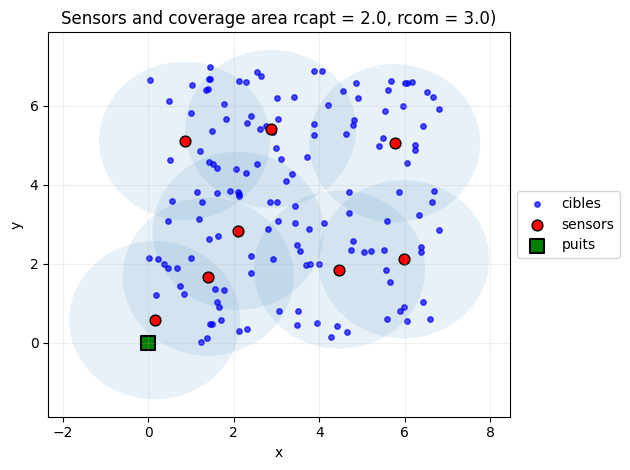

In [ ]:
cibles = file_to_instance("../Projet-Meta-Heuristiques/Projet de métaheuristiques - Instances cibles générées aléatoirement/captANOR150_7_4.dat")
solver = SensorCoverageSolver(cibles, rcapt, rcom, puits)
sensors = solver.greedy_initial(False)
plot_solution(cibles,sensors,".",rcapt,rcom,False)

/tmp/ipykernel_1964/2142936045.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.random.choice(list(cur_sol),1)) # choose one sensor to remove


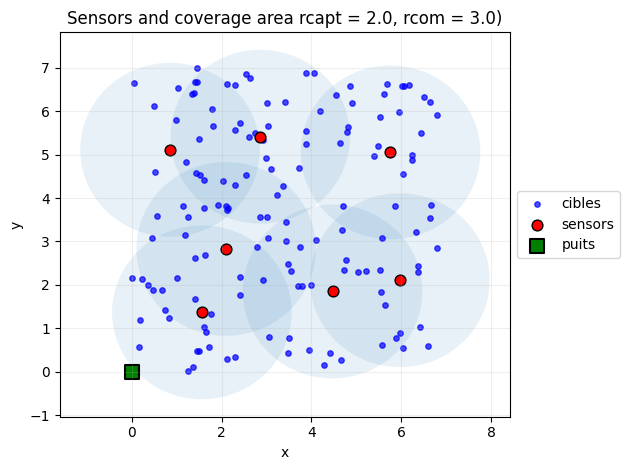

In [ ]:
neighbor = solver.solution_to_neighbor()
plot_solution(cibles,neighbor,"Voisinage/example1_rand_23.pdf",rcapt,rcom)

/tmp/ipykernel_1964/2142936045.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.random.choice(list(cur_sol),1)) # choose one sensor to remove


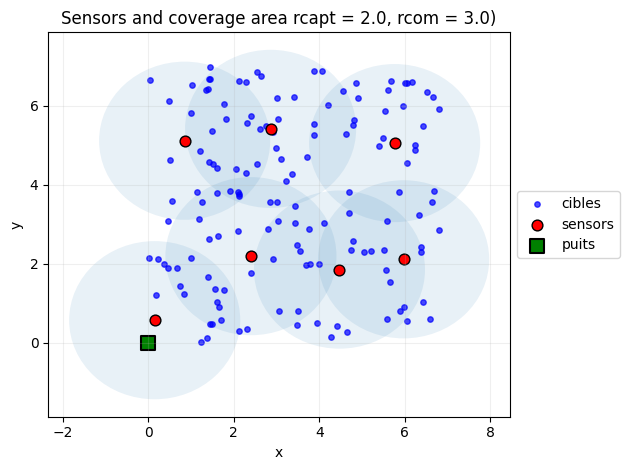

In [ ]:
neighbor = solver.solution_to_neighbor()
plot_solution(cibles,neighbor,"Voisinage/example2_rand_23.pdf",rcapt,rcom,)

/tmp/ipykernel_1964/2142936045.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.random.choice(list(cur_sol),1)) # choose one sensor to remove


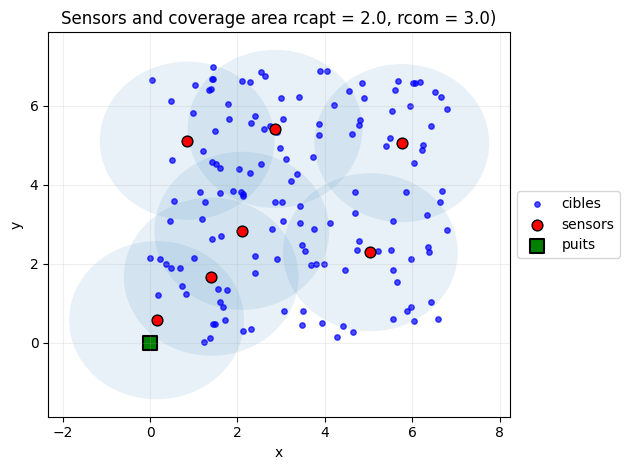

In [ ]:
neighbor = solver.solution_to_neighbor()
plot_solution(cibles,neighbor,"Voisinage/example3_rand_23.pdf",rcapt,rcom)